In [32]:
# -*- coding:utf-8 -*-

import os
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense#全连接层
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import tushare as ts

import time
TODAY = time.strftime("%Y%m%d")

from datetime import datetime
from datetime import timedelta

matplotlib.rcParams['font.family'] = 'STSong' 

HIS_RECORD_START = '20100701' #历史数据起始时间
HIS_STRAT_BEFORE = '20100501' #用于回溯计算最初X个历史样本的MA和EMA等
TIMESTEPS = 30  #相关(观察期)的时间序列步数
PREDICT_NUM = 5 #向前预测的周期数
CYCLE = 6 #训练集向后（历史方向）退的周期数

CODE_LIST=['000001.SH','399006.SZ']

INDICATOR = ['upper_band','lower_band','macd_diff','macd_dea','kdj_k','kdj_d','rsi_6','rsi_14','ar','br'] #考虑到macd指标的bar与diff & dea共线，故弃之；kdj中的j同理
OHLC = ['open','high','low','close','vol','amount']
INPUT_LIST = OHLC + INDICATOR + ['trade_date']
_INPUT_LIST = ['T0'] + INPUT_LIST #T0为观察日最后一天的收盘价
INDEXSUMMARY = ['total_mv','float_mv','turnover_rate','turnover_rate_f','pe','pe_ttm','pb']
CORV_INPUT_LIST = INDEXSUMMARY + ['IFL_close','IFL_settle','1w','trade_date']

print(_INPUT_LIST)
print(CORV_INPUT_LIST)

['T0', 'open', 'high', 'low', 'close', 'vol', 'amount', 'upper_band', 'lower_band', 'macd_diff', 'macd_dea', 'kdj_k', 'kdj_d', 'rsi_6', 'rsi_14', 'ar', 'br', 'trade_date']
['total_mv', 'float_mv', 'turnover_rate', 'turnover_rate_f', 'pe', 'pe_ttm', 'pb', 'IFL_close', 'IFL_settle', '1w', 'trade_date']


In [33]:
def generate_data(seq, start_col):
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入，第i+TIMESTEPS 到第i+TIMESTEPS+PREDICT_NUM-1项作为输出
    X = []
    y = []
    for i in range(len(seq) - TIMESTEPS - PREDICT_NUM + 1):
        #print(i)
        X.append(seq[i:i + TIMESTEPS,start_col:-1]) # 前start-col列不作为输入，最后1列"trace_date"不作为输入
        yj = np.array(seq[i + TIMESTEPS:i + TIMESTEPS + PREDICT_NUM,0] / seq[i + TIMESTEPS -1,0]) - 1
        #print("yj: ",yj.shape)
        # print(yj)
        y.append(yj) 
        # y为未来PREDICT_NUM日的收盘价除以最后一个观察日的收盘价 - 1，长度为PREDICT_NUM
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [34]:
def generate_data_pred(seq, start_col):
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入
    X = []
    for i in range(len(seq) - TIMESTEPS + 1):
        X.append(seq[i:i + TIMESTEPS,start_col:-1]) # 前start-col列不作为输入，最后1列"trace_date"不作为输入
    return np.array(X, dtype=np.float32)

In [35]:
# Tushare 2000条限制调用，通用封装函数

def my_daily(func,ts_code=None):  
    filename = 'cache_data\\' + func + '_hist.xls'
    print("filename: ",filename)
    sheet = pd.DataFrame()
    sheet_ = pd.DataFrame()

    try:
        f =open(filename,'r')
        f.close()
    except IOError:
        for _ in range(3):
            try:
                print("Load history data from toshare...", ts_code)
                if (ts_code is None): 
                    cmd = "pro.{}(end_date='20180101')".format(func) #{}替换，实现动态函数名
                    print(cmd)
                    sheet = eval(cmd)
                else:
                    cmd = "pro.{}(ts_code='{}',end_date='20180101')".format(func,ts_code)
                    print(cmd)
                    sheet = eval(cmd) 
            except:
                time.sleep(2)
            else:
                print("Write historty data to excel...")
                sheet.to_excel(filename,index=False)
                break
    else:
        print("Read historty data from excel...")
        sheet = pd.read_excel(io=filename)

    filename = 'cache_data\\' + func + TODAY + '_delta.xls'
    print("filename: ",filename)
    try:
        f =open(filename,'r')
        f.close()
    except IOError:
        for _ in range(3):
            try:
                print("Load delta data from toshare...", ts_code)
                # print("np.isnan(ts_code): ", ts_code == None)
                if (ts_code is None): 
                    cmd = "pro.{}(start_date='20180101',end_date='{}')".format(func,TODAY) #{}替换，实现动态函数名
                    print(cmd)
                    sheet_ = eval(cmd)
                else:
                    cmd = "pro.{}(ts_code='{}',start_date='20180101',end_date='{}')".format(func,ts_code,TODAY)
                    print(cmd)
                    sheet_ = eval(cmd) 
            except:
                time.sleep(2)
            else:
                print("Write delta data to excel...")
                sheet_.to_excel(filename,index=False)
                sheet = pd.concat([sheet,sheet_], axis=0)
                return sheet
    else:
        print("Read delta data from excel...")
        sheet_ = pd.read_excel(io=filename)
        sheet = pd.concat([sheet,sheet_], axis=0)
        return sheet

In [36]:
datatps={
'ts_code':      np.str,
'trade_date':   np.str,
'close':        np.float64,
'open':         np.float64,
'high':         np.float64,
'low':          np.float64,
'pre_close':    np.float64,
'change':       np.float64,
'pct_chg':      np.float64,
'vol':          np.float64,
'amount':       np.float64
}

print(datatps)

def my_index_daily(ts_code, start_date):  
    filename = 'cache_data\\' + ts_code + TODAY + '.xls'
    print("filename: ",filename)
    try:
        f =open(filename,'r')
        f.close()
    except IOError:
        for _ in range(3):
            try:
                print("Load from toshare...")
                sheet = pro.index_daily(ts_code=ts_code, start_date=start_date)
            except:
                time.sleep(2)
            else:
                print("Write to excel...")
                sheet.to_excel(filename,index=False)
                return sheet
    else:
        print("Read from excel...")
        sheet = pd.read_excel(io=filename,dtype=datatps)
        return sheet

{'ts_code': <class 'str'>, 'trade_date': <class 'str'>, 'close': <class 'numpy.float64'>, 'open': <class 'numpy.float64'>, 'high': <class 'numpy.float64'>, 'low': <class 'numpy.float64'>, 'pre_close': <class 'numpy.float64'>, 'change': <class 'numpy.float64'>, 'pct_chg': <class 'numpy.float64'>, 'vol': <class 'numpy.float64'>, 'amount': <class 'numpy.float64'>}


In [37]:
time.gmtime(1551888000)

time.struct_time(tm_year=2019, tm_mon=3, tm_mday=6, tm_hour=16, tm_min=0, tm_sec=0, tm_wday=2, tm_yday=65, tm_isdst=0)

In [38]:
str(int(time.mktime(time.strptime(TODAY,'%Y%m%d'))))

'1556985600'

In [39]:
# 根据注册Tushare获得的token，填入参数
pro = ts.pro_api('********************************************************') # 自行填写

In [40]:
df = pro.fut_basic(exchange='CFFEX', fut_type='2')
df

,ts_code,symbol,exchange,name,fut_code,multiplier,trade_unit,per_unit,quote_unit,quote_unit_desc,d_mode_desc,list_date,delist_date,d_month,last_ddate
0,IFL.CFX,IFL,CFFEX,沪深300期货当月,IF,None,None,None,None,None,None,None,None,None,None
1,IHL2.CFX,IHL2,CFFEX,上证50期货当季连续,IH,None,None,None,None,None,None,None,None,None,None
2,TL2.CFX,TL2,CFFEX,10年期国债期货隔季连续,T,None,None,None,None,None,None,None,None,None,None
3,IF.CFX,IF,CFFEX,CFFEX沪深300期货,IF,None,None,None,None,None,None,None,None,None,None
4,TS.CFX,TS,CFFEX,CFFEX2年期国债期货,TS,None,None,None,None,None,None,None,None,None,None
5,TFL1.CFX,TFL1,CFFEX,5年期国债期货下季连续,TF,None,None,None,None,None,None,None,None,None,None
6,IFL2.CFX,IFL2,CFFEX,沪深300期货当季,IF,None,None,None,None,None,None,None,None,None,None
7,TL.CFX,TL,CFFEX,10年期国债期货当季连续,T,None,None,None,None,None,None,None,None,None,None
8,IC.CFX,IC,CFFEX,CFFEX中证500期货,IC,None,None,None,None,None,None,None,None,None,None
9,ICL1.CFX,ICL1,CFFEX,中证500期货次月连续,IC,None,None,None,None,None,None,None,None,None,None


In [41]:
df_shibor = my_daily(func="shibor")

df_shibor.rename(columns={'date':'trade_date'}, inplace = True)
df_shibor['trade_date'] = df_shibor['trade_date'].astype(str)
df_shibor.sort_values(by=['trade_date'],inplace=True)
df_shibor

filename:  cache_data\shibor_hist.xls
Read historty data from excel...
filename:  cache_data\shibor20190505_delta.xls
Read delta data from excel...


,trade_date,on,1w,2w,1m,3m,6m,9m,1y
1999,20091229,1.1492,1.5788,1.7992,1.7975,1.8318,1.9095,2.0599,2.2502
1998,20091230,1.1488,1.5808,1.7650,1.7990,1.8324,1.9098,2.0599,2.2502
1997,20091231,1.1467,1.5650,1.6825,1.7945,1.8319,1.9100,2.0600,2.2502
1996,20100104,1.1175,1.4225,1.6650,1.7728,1.8312,1.9100,2.0600,2.2502
1995,20100105,1.1150,1.4004,1.6023,1.7580,1.8298,1.9109,2.0600,2.2501
1994,20100106,1.1183,1.4002,1.5696,1.7513,1.8288,1.9116,2.0600,2.2501
1993,20100107,1.0797,1.3942,1.4968,1.7444,1.8321,1.9155,2.0634,2.2551
1992,20100108,1.0608,1.3993,1.4608,1.7463,1.8369,1.9203,2.0679,2.2594
1991,20100111,1.0471,1.3696,1.4217,1.7401,1.8403,1.9232,2.0719,2.2629
1990,20100112,1.0336,1.4354,1.4292,1.7392,1.8439,1.9280,2.0779,2.2682


In [42]:
df_fut = my_daily(func='fut_daily',ts_code='IF.CFX')
df_fut.rename(columns={'settle':'IFL_settle'}, inplace = True)
df_fut.rename(columns={'close':'IFL_close'}, inplace = True)
df_fut['trade_date'] = df_fut['trade_date'].astype(str)
df_fut.sort_values(by=['trade_date'],inplace=True)
df_fut

filename:  cache_data\fut_daily_hist.xls
Read historty data from excel...
filename:  cache_data\fut_daily20190505_delta.xls
Read delta data from excel...


,ts_code,trade_date,pre_close,pre_settle,open,high,low,IFL_close,IFL_settle,change1,change2,vol,amount,oi,oi_chg
1875,IF.CFX,20100416,NaN,3399.0,3450.0,3488.0,3413.2,3415.6,3431.2,16.6,32.2,48988,5.053881e+06,2702,NaN
1874,IF.CFX,20100419,3415.6,3431.2,3396.0,3398.0,3166.2,3197.4,3201.2,-233.8,-230.0,109733,1.082064e+07,3954,NaN
1873,IF.CFX,20100420,3197.4,3201.2,3209.2,3240.0,3168.8,3214.6,3216.6,13.4,15.4,141862,1.363421e+07,4496,NaN
1872,IF.CFX,20100421,3214.6,3216.6,3215.0,3281.2,3208.0,3267.2,3266.0,50.6,49.4,114531,1.112679e+07,5062,NaN
1871,IF.CFX,20100422,3267.2,3266.0,3260.2,3274.4,3211.0,3236.2,3240.0,-29.8,-26.0,133247,1.296298e+07,5383,NaN
1870,IF.CFX,20100423,3236.2,3240.0,3241.0,3266.0,3221.0,3221.2,3235.6,-18.8,-4.4,116981,1.138868e+07,5808,NaN
1869,IF.CFX,20100426,3221.2,3235.6,3243.0,3252.0,3211.8,3219.6,3224.8,-16.0,-10.8,112229,1.089497e+07,7079,NaN
1868,IF.CFX,20100427,3219.6,3224.8,3201.2,3205.0,3107.6,3138.8,3121.8,-86.0,-103.0,139961,1.320072e+07,7386,NaN
1867,IF.CFX,20100428,3138.8,3121.8,3101.6,3142.6,3094.2,3129.0,3132.8,7.2,11.0,128530,1.204703e+07,7092,NaN
1866,IF.CFX,20100429,3129.0,3132.8,3141.0,3157.6,3082.2,3083.8,3114.4,-49.0,-18.4,116254,1.094157e+07,8705,NaN


In [43]:
df_aplus = my_daily(func='index_dailybasic',ts_code='000001.SH')
for idx in INDEXSUMMARY :
    exec("df_aplus['{}'] = df_aplus['{}'].astype(float)".format(idx,idx))
df_aplus.dtypes

filename:  cache_data\index_dailybasic_hist.xls
Read historty data from excel...
filename:  cache_data\index_dailybasic20190505_delta.xls
Read delta data from excel...


ts_code             object
trade_date           int64
total_mv           float64
float_mv           float64
total_share          int64
float_share          int64
free_share           int64
turnover_rate      float64
turnover_rate_f    float64
pe                 float64
pe_ttm             float64
pb                 float64
dtype: object

In [44]:
# 取指数的日特征数据
df_a_list = []
df_aa_list = []

for n in range(len(CODE_LIST)):
    df_a = my_index_daily(ts_code=CODE_LIST[n], start_date=HIS_STRAT_BEFORE)
    
    df_a.sort_values(by=['trade_date'],inplace=True)

    print("initial df_a: ")
    print(df_a.tail())
    
    # Create Moving Average & Create Bollinger Bands
    df_a['ma21'] = df_a['close'].rolling(window=21,center=False).mean()

    df_a['20sd'] = df_a['close'].rolling(window=20,center=False).std()
    df_a['upper_band'] = df_a['ma21'] + (df_a['20sd']*2)
    df_a['lower_band'] = df_a['ma21'] - (df_a['20sd']*2)
    
    # Create MACD
    df_a['26ema'] = df_a['close'].ewm(span=26,min_periods=1,adjust=True,ignore_na=False).mean()
    df_a['12ema'] = df_a['close'].ewm(span=12,min_periods=1,adjust=True,ignore_na=False).mean()
    df_a['macd_diff'] = df_a['12ema']-df_a['26ema']
    df_a['macd_dea'] = df_a['macd_diff'].ewm(span=9,min_periods=1,adjust=True,ignore_na=False).mean()
    df_a['macd_bar'] = 2*(df_a['macd_diff'] - df_a['macd_dea'])

    # Create KDJ indicator
    df_a['lowL'] = df_a['low'].rolling(window=9,center=False).min()
    df_a['lowL'].fillna(value=df_a['low'].expanding(min_periods=1).min(), inplace=True)
    
    df_a['highL'] = df_a['high'].rolling(window=9,center=False).max()
    df_a['highL'].fillna(value=df_a['high'].expanding(min_periods=1).max(), inplace=True)
    
    df_a['rsv'] = (df_a['close'] - df_a['lowL']) / (df_a['highL'] - df_a['lowL']) * 100
    df_a['kdj_k'] = df_a['rsv'].ewm(com=2,min_periods=1,adjust=True,ignore_na=False).mean()
    df_a['kdj_d'] = df_a['kdj_k'].ewm(com=2,min_periods=1,adjust=True,ignore_na=False).mean()
    df_a['kdj_j'] = 3 * df_a['kdj_k'] - 2 * df_a['kdj_d']

    # Create RSI indicator
    df_a['value']=df_a['close']-df_a['close'].shift(1)
    df_a['value1']=df_a['value']
    df_a['value1'][df_a['value1'] < 0] = 0
    df_a['value2']=df_a['value']
    df_a['value2'][df_a['value2'] > 0] = 0
    df_a['plus_6']=df_a['value1'].rolling(window=6,center=False).sum()
    df_a['minus_6']=df_a['value2'].rolling(window=6,center=False).sum()
    df_a['plus_14']=df_a['value1'].rolling(window=14,center=False).sum()
    df_a['minus_14']=df_a['value2'].rolling(window=14,center=False).sum()
    
    df_a['rsi_6']=df_a['plus_6']/(df_a['plus_6']-df_a['minus_6'])*100
    df_a['rsi_14']=df_a['plus_14']/(df_a['plus_14']-df_a['minus_14'])*100
    
    # Create ARBR indicator
    df_a['ho'] = df_a['high'] - df_a['open']
    df_a['ol'] = df_a['open'] - df_a['low']
    df_a['hcy'] = df_a['high'] - df_a['close'].shift(1)
    df_a['cyl'] = df_a['close'].shift(1) - df_a['low']
    
    df_a['ar'] = df_a['ho'].rolling(window=26).sum() / df_a['ol'].rolling(window=26).sum()
    df_a['br'] = df_a['hcy'].rolling(window=26).sum() / df_a['cyl'].rolling(window=26).sum()

    df_a.fillna(0,inplace=True)


    df_a['T0'] = df_a['close']
    df_a['vol'] = df_a['vol'].astype(float)
    
    df_a = df_a[df_a['trade_date'] >= HIS_RECORD_START] #只保留训练开始时点之后的记录
    
    print("df_a: ",df_a.dtypes)
    print(df_a.tail())

    df_a_list.append(df_a)
    
    # 以下为辅助特征df_aa
    df_aplus = my_daily(func='index_dailybasic',ts_code=CODE_LIST[n])
    for idx in INDEXSUMMARY :
        exec("df_aplus['{}'] = df_aplus['{}'].astype(float)".format(idx,idx))
    df_aplus['trade_date'] = df_aplus['trade_date'].astype(str)
    
    df_tmp = pd.merge(df_a[['trade_date']],df_aplus, how='left', on='trade_date')
    df_tmp = pd.merge(df_tmp,df_shibor[['trade_date','1w']], how='left', on='trade_date')

    df_tmp = pd.merge(df_tmp,df_fut[['trade_date','IFL_close','IFL_settle']], how='left', on='trade_date')
    df_aa = df_tmp
    df_aa.fillna(axis=0,method='ffill',inplace=True) 
    
    print("df_aa: ",df_aa.dtypes)
    print(df_aa.tail())

    df_aa_list.append(df_aa)
    del(df_a,df_aa)

filename:  cache_data\000001.SH20190505.xls
Read from excel...
initial df_a: 
     ts_code trade_date      close       open       high        low  \
4  000001.SH   20190424  3201.6137  3203.5588  3210.6508  3156.6070   
3  000001.SH   20190425  3123.8261  3190.5851  3193.7494  3123.0258   
2  000001.SH   20190426  3086.3989  3108.1635  3129.2134  3085.8049   
1  000001.SH   20190429  3062.4985  3090.6331  3107.7605  3050.0261   
0  000001.SH   20190430  3078.3389  3052.6223  3088.4074  3052.6223   

   pre_close   change  pct_chg          vol       amount  
4  3198.5938   3.0199   0.0944  274872164.0  278410852.5  
3  3201.6137 -77.7876  -2.4296  325879129.0  309076083.7  
2  3123.8261 -37.4272  -1.1981  280873854.0  274776402.3  
1  3086.3989 -23.9004  -0.7744  292114886.0  289063278.9  
0  3062.4985  15.8404   0.5172  222302517.0  225498129.2  


C:\ProgramData\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda2\envs\python37\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


df_a:  ts_code        object
trade_date     object
close         float64
open          float64
high          float64
low           float64
pre_close     float64
change        float64
pct_chg       float64
vol           float64
amount        float64
ma21          float64
20sd          float64
upper_band    float64
lower_band    float64
26ema         float64
12ema         float64
macd_diff     float64
macd_dea      float64
macd_bar      float64
lowL          float64
highL         float64
rsv           float64
kdj_k         float64
kdj_d         float64
kdj_j         float64
value         float64
value1        float64
value2        float64
plus_6        float64
minus_6       float64
plus_14       float64
minus_14      float64
rsi_6         float64
rsi_14        float64
ho            float64
ol            float64
hcy           float64
cyl           float64
ar            float64
br            float64
T0            float64
dtype: object
     ts_code trade_date      close       open       hig

In [45]:
#显示所有列
pd.set_option('display.max_columns', None)

In [46]:
df_a_list[1].tail()

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount,ma21,20sd,upper_band,lower_band,26ema,12ema,macd_diff,macd_dea,macd_bar,lowL,highL,rsv,kdj_k,kdj_d,kdj_j,value,value1,value2,plus_6,minus_6,plus_14,minus_14,rsi_6,rsi_14,ho,ol,hcy,cyl,ar,br,T0
4,399006.SZ,20190424,1718.8461,1690.2788,1721.4213,1676.6381,1683.8000,35.0461,2.0814,86336153.0,99574814.6,1706.927510,40.121419,1787.170347,1626.684672,1687.420028,1705.460390,18.040363,26.862741,-17.644757,1638.2969,1729.2093,88.600895,63.391113,53.189137,83.795064,35.0461,35.0461,0.0000,66.2031,-44.8857,112.0601,-161.3921,59.594757,40.979776,31.1425,13.6407,37.6213,7.1619,0.842017,0.937176,1718.8461
3,399006.SZ,20190425,1669.9777,1709.8287,1723.6622,1669.2360,1718.8461,-48.8684,-2.8431,103488546.0,112522886.9,1708.822148,37.605124,1784.032396,1633.611900,1686.128003,1700.001515,13.873512,24.264895,-20.782768,1638.2969,1729.2093,34.847612,53.876612,53.418295,54.793246,-48.8684,0.0000,-48.8684,46.2945,-93.7541,102.9754,-210.2605,33.056025,32.874712,13.8335,40.5927,4.8161,49.6101,0.783943,0.844396,1669.9777
2,399006.SZ,20190426,1657.8243,1664.0430,1682.4578,1653.6913,1669.9777,-12.1534,-0.7278,82295686.0,96658518.9,1709.776981,34.394474,1778.565928,1640.988034,1684.031433,1693.512713,9.481280,21.308172,-23.653785,1638.2969,1729.2093,21.479358,43.077528,49.971373,29.289837,-12.1534,0.0000,-12.1534,46.2945,-93.0170,102.9754,-184.8062,33.230925,35.782482,18.4148,10.3517,12.4801,16.2864,0.863863,0.935914,1657.8243
1,399006.SZ,20190429,1615.6164,1658.1915,1661.0592,1611.2157,1657.8243,-42.2079,-2.5460,89788375.0,104464841.2,1709.243538,40.666989,1790.577516,1627.909560,1678.963653,1681.528665,2.565012,17.559540,-29.989057,1611.2157,1729.2093,3.729609,29.961555,43.301433,3.281797,-42.2079,0.0000,-42.2079,35.0461,-135.2249,101.4599,-227.0141,20.582542,30.888259,2.8677,46.9758,3.2349,46.6086,0.752231,0.830295,1615.6164
0,399006.SZ,20190430,1623.7819,1612.1090,1634.7120,1608.7209,1615.6164,8.1655,0.5054,67089716.0,75753578.5,1705.921367,43.123844,1792.169056,1619.673678,1674.876115,1672.644547,-2.231568,13.601319,-31.665774,1608.7209,1723.6622,13.103210,24.342106,36.981658,-0.936996,8.1655,8.1655,0.0000,43.2116,-116.9418,109.6254,-212.4799,26.981382,34.034026,22.6030,3.3881,19.0956,6.8955,0.848962,0.924341,1623.7819


In [47]:
# 清理model/train/目录
import os

def  del_file(path_):
    for i in os.listdir(path_):
        path_file = os.path.join(path_,i)  #取文件绝对路径
        if os.path.isfile(path_file):
            os.remove(path_file) #删除文件
        else:
            del_file(path_file) #递归删除子目录

del_file("model/train")

In [48]:
import re
from os import walk
from os import path

s = "lstm-00-02-0.001861.hdf5"
p = re.compile(r'.*(?=.hdf5)')

print(s.split("-"))

re.findall(p,s.split("-")[-1])[0]

['lstm', '00', '02', '0.001861.hdf5']


'0.001861'

df1.columns:  Index(['T0', 'open', 'high', 'low', 'close', 'vol', 'amount', 'upper_band',
       'lower_band', 'macd_diff', 'macd_dea', 'kdj_k', 'kdj_d', 'rsi_6',
       'rsi_14', 'ar', 'br', 'trade_date'],
      dtype='object')
norm_data:  <class 'numpy.ndarray'>
(2118, 18)
(2118, 18)
x shape:  (2084, 30, 16)
x2 shape:  (2084, 30, 10)
y shape:  (2084, 5)
z:  Tensor("concatenate_3/concat:0", shape=(?, 200), dtype=float32)
main_out,combo_out Tensor("main_out_4/BiasAdd:0", shape=(?, 5), dtype=float32) Tensor("combo_out_4/BiasAdd:0", shape=(?, 5), dtype=float32)
^(lstm-0)+.*hdf5
loading tuned model: model/tune\lstm-0-05-0.016377.hdf5
(2084, 30, 16) (2084, 30, 10) (2084, 5)
Train on 1771 samples, validate on 313 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 0.01767, saving model to model/train/lstm-0-01-0.017666.hdf5
 - 21s - loss: 0.0291 - main_out_loss: 0.0270 - combo_out_loss: 0.0296 - val_loss: 0.0177 - val_main_out_loss: 0.0175 - val_combo_out_loss: 0.0177
Epoch 2/5
Epo

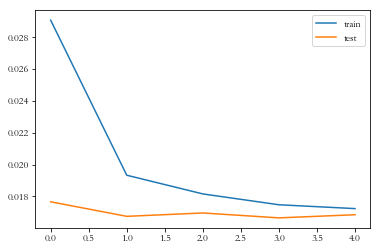

df1.columns:  Index(['T0', 'open', 'high', 'low', 'close', 'vol', 'amount', 'upper_band',
       'lower_band', 'macd_diff', 'macd_dea', 'kdj_k', 'kdj_d', 'rsi_6',
       'rsi_14', 'ar', 'br', 'trade_date'],
      dtype='object')
norm_data:  <class 'numpy.ndarray'>
(2118, 18)
(2118, 18)
x shape:  (2084, 30, 16)
x2 shape:  (2084, 30, 10)
y shape:  (2084, 5)
z:  Tensor("concatenate_4/concat:0", shape=(?, 200), dtype=float32)
main_out,combo_out Tensor("main_out_6/BiasAdd:0", shape=(?, 5), dtype=float32) Tensor("combo_out_6/BiasAdd:0", shape=(?, 5), dtype=float32)
^(lstm-1)+.*hdf5
loading tuned model: model/tune\lstm-1-04-0.025096.hdf5
(2084, 30, 16) (2084, 30, 10) (2084, 5)
Train on 1771 samples, validate on 313 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 0.02752, saving model to model/train/lstm-1-01-0.027520.hdf5
 - 22s - loss: 0.0365 - main_out_loss: 0.0365 - combo_out_loss: 0.0365 - val_loss: 0.0275 - val_main_out_loss: 0.0276 - val_combo_out_loss: 0.0275
Epoch 2/5
Epo

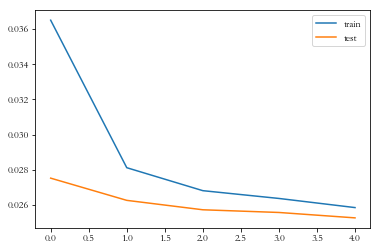

In [49]:
# LSTM 2
import random

from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import concatenate
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint

NUM_UNIT = 100
BATCH_SIZE = 32 
TRAINING_STEPS = 5
DROP_OUT = 0.2
VERBOSE_ = 2
WEIGHT = 0.2  # Weight of RNN based on y only 
VALIDATION_ = 0.15
LOSS = 'mae'

scaler_list2 = []
model_list2 = []
tuned_model_list2 = []
tuned_model_hdf5 = []

for n in range(len(CODE_LIST)):
    df1 = df_a_list[n].sort_values(by=['trade_date'])[_INPUT_LIST][:-CYCLE*PREDICT_NUM]
    df2 = df_aa_list[n].sort_values(by=['trade_date'])[CORV_INPUT_LIST][:-(CYCLE+1)*PREDICT_NUM]

    # print(df1.tail())
    # print(df2.tail())
    
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(df1.iloc[:,1:-1]) # T0保留原值，不做归一化处理

    scaler2 = StandardScaler()
    norm_data2 = scaler2.fit_transform(df2.iloc[:,:-1])
    
    scaler_list2.append((scaler,scaler2))
    # print("scaler: ",scaler.scale_,scaler.mean_,scaler.var_ ,scaler.n_samples_seen_)
    
    print("df1.columns: ",df1.columns)
    norm_data = np.concatenate([np.asarray(df1.iloc[:,0:1]), norm_data, np.asarray(df1.iloc[:,-1:])],axis=1)
    norm_data2 = np.concatenate([norm_data2, np.asarray(df2.iloc[:,-1:])],axis=1)
    
    print("norm_data: ",type(norm_data))
    print(norm_data.shape)
    # print(norm_data[-7:])
    del(df1,df2,scaler,scaler2)
    
    print(norm_data.shape)
    x,y=generate_data(norm_data,1)
    x2=generate_data_pred(norm_data2,0)
    print("x shape: ",x.shape)
    # print(x[-6:])
    print("x2 shape: ",x2.shape)
    # print(x2[-6:])
    print("y shape: ",y.shape)
    # print(y[-6:])
    
    main_in = Input(shape=(TIMESTEPS,len(INPUT_LIST)-1), dtype='float32', name='main_in')
    main_lstm = LSTM(NUM_UNIT,return_sequences=True,dropout=0,recurrent_dropout=0)(main_in)
    main_lstm = Dropout(DROP_OUT)(main_lstm)
    main_lstm = LSTM(NUM_UNIT,return_sequences=True,dropout=0,recurrent_dropout=0)(main_lstm)
    main_lstm = LSTM(NUM_UNIT,return_sequences=False,dropout=0,recurrent_dropout=0)(main_lstm)
    main_lstm = Dropout(DROP_OUT)(main_lstm)
    main_out = Dense(PREDICT_NUM,activation='linear', name='main_out')(main_lstm)
    # print(main_lstm)
    
    exo_in = Input(shape=(TIMESTEPS,len(CORV_INPUT_LIST)-1), dtype='float32', name='exo_in')
    exo_lstm = LSTM(NUM_UNIT,return_sequences=True,dropout=0,recurrent_dropout=0)(exo_in)
    exo_lstm = Dropout(DROP_OUT)(exo_lstm)
    exo_lstm = LSTM(NUM_UNIT,return_sequences=True,dropout=0,recurrent_dropout=0)(exo_lstm)
    exo_lstm = LSTM(NUM_UNIT,return_sequences=False,dropout=0,recurrent_dropout=0)(exo_lstm)
    exo_lstm = Dropout(DROP_OUT)(exo_lstm)
    # print(exo_lstm)
    
    z = concatenate([main_lstm, exo_lstm])
    print("z: ",z)

    combo_out = Dense(PREDICT_NUM, activation='linear', name='combo_out')(z)
    print("main_out,combo_out",main_out,combo_out)
  
    r='^(lstm-' + str(n) + ')+.*hdf5'
    print(r)

    path_ = "model/tune"
    path_file = ""
    for fi in os.listdir(path_):
        path_file = os.path.join(path_,fi)  #取文件绝对路径
        # print(path_file)
        if os.path.isfile(path_file):
            res=re.search(r,fi)                  #查找指定正则的文件名
            if res:
                break

    tuned_model_hdf5.append(path_file)
    print("loading tuned model: " + path_file)

    
    tuned_model = Model(inputs=[main_in, exo_in], outputs=[main_out, combo_out])
    model = Model(inputs=[main_in, exo_in], outputs=[main_out, combo_out])


    tuned_model = load_model(path_file)
    # tuned_model.compile(optimizer='adam', loss=LOSS, loss_weights=[WEIGHT, 1-WEIGHT]) # 调试代码，正式运行需注掉

    model.compile(optimizer='adam', loss=LOSS, loss_weights=[WEIGHT, 1-WEIGHT])

    # checkpoint
    filepath = "model/train/lstm-" + str(n) + "-{epoch:02d}-{val_loss:.6f}.hdf5"
    # 中途训练效果提升, 则将文件保存, 每提升一次, 保存一次
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    # shuffle
    np.random.seed(1024)
    index = list(range(len(x)))
    random.shuffle(index)
    x_data = x[index]
    x_data2 = x2[index]
    y_label = y[index]
    print(x_data.shape,x_data2.shape,y_label.shape)

    # Fit 
    fcst = model.fit(x={'main_in': x_data, 'exo_in': x_data2}, \
                     y={'main_out': y_label,'combo_out': y_label}, \
                     batch_size=BATCH_SIZE, epochs=TRAINING_STEPS,verbose=VERBOSE_,validation_split=VALIDATION_, \
                     callbacks=callbacks_list, shuffle=False)

    print(fcst)
    # print(dir(fcst.history))

    # plot history
    plt.plot(fcst.history['loss'], label='train')
    plt.plot(fcst.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    # tuned_model = model # 调试代码，正式运行需注掉
        
    model_list2.append(model)
    tuned_model_list2.append(tuned_model)
    del(model,tuned_model,norm_data,norm_data2)


In [50]:
tuned_model_list2[1].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_in (InputLayer)            (None, 30, 16)       0                                            
__________________________________________________________________________________________________
exo_in (InputLayer)             (None, 30, 10)       0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 30, 100)      46800       main_in[0][0]                    
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 30, 100)      44400       exo_in[0][0]                     
__________________________________________________________________________________________________
dropout_5 

In [51]:
# 装入/model/train下最佳LSTM模型
import re
from os import walk
from os import path
from keras.models import Model,load_model

del(model_list2)
model_list2 = []
best_trained_hdf5 = []

for n in range(len(CODE_LIST)):

    p = re.compile(r'.*(?=.hdf5)')

    r='^(lstm-' + str(n) + ')+.*hdf5'
    print(r)

    for parent,dirNames,fileNames in walk("model/train"):  #根据os.walk输出目录信息
        ff_list = []
        floss_list = []
        for fileName in fileNames:                     #遍历所有文件名
            res=re.search(r,fileName)                  #查找指定正则的文件名
            if res:
                print(path.join(parent,fileName))     #拼接目录和文件名，输出
                # print(parent,dirNames,fileName)
                ff_list.append(fileName)
                floss_list.append(float(re.findall(p,fileName.split("-")[-1])[0]))

        idx = floss_list.index(min(floss_list))
        print(idx)
        fpath = "model/train/" + ff_list[idx]
        print(fpath)

    best_trained_hdf5.append(fpath)
    print("loading trained model: " + fpath)
    model = load_model(fpath)
    # model.compile(optimizer='adam', loss=LOSS, loss_weights=[WEIGHT, 1-WEIGHT])

    model_list2.append(model)
    del(model)

^(lstm-0)+.*hdf5
model/train\lstm-0-01-0.017666.hdf5
model/train\lstm-0-02-0.016753.hdf5
model/train\lstm-0-04-0.016657.hdf5
2
model/train/lstm-0-04-0.016657.hdf5
loading trained model: model/train/lstm-0-04-0.016657.hdf5
^(lstm-1)+.*hdf5
model/train\lstm-1-01-0.027520.hdf5
model/train\lstm-1-02-0.026256.hdf5
model/train\lstm-1-03-0.025720.hdf5
model/train\lstm-1-04-0.025567.hdf5
model/train\lstm-1-05-0.025260.hdf5
4
model/train/lstm-1-05-0.025260.hdf5
loading trained model: model/train/lstm-1-05-0.025260.hdf5


          T0       open       high        low      close          vol  \
4  3201.6137  3203.5588  3210.6508  3156.6070  3201.6137  274872164.0   
3  3123.8261  3190.5851  3193.7494  3123.0258  3123.8261  325879129.0   
2  3086.3989  3108.1635  3129.2134  3085.8049  3086.3989  280873854.0   
1  3062.4985  3090.6331  3107.7605  3050.0261  3062.4985  292114886.0   
0  3078.3389  3052.6223  3088.4074  3052.6223  3078.3389  222302517.0   

        amount   upper_band   lower_band  macd_diff   macd_dea      kdj_k  \
4  278410852.5  3334.796519  3031.994833  53.135045  65.400776  50.970894   
3  309076083.7  3322.584527  3056.276416  42.164174  60.753456  34.151094   
2  274776402.3  3300.131832  3084.793806  30.102613  54.623287  22.869624   
1  289063278.9  3310.047586  3081.311871  18.403037  47.379237  17.058238   
0  225498129.2  3321.412881  3068.763805  10.290604  39.961511  15.485060   

       kdj_d      rsi_6     rsi_14        ar        br trade_date  
4  60.506741  28.020579  47.53

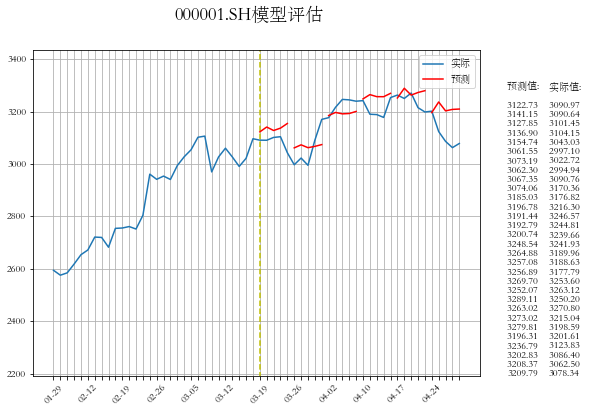

          T0       open       high        low      close          vol  \
4  1718.8461  1690.2788  1721.4213  1676.6381  1718.8461   86336153.0   
3  1669.9777  1709.8287  1723.6622  1669.2360  1669.9777  103488546.0   
2  1657.8243  1664.0430  1682.4578  1653.6913  1657.8243   82295686.0   
1  1615.6164  1658.1915  1661.0592  1611.2157  1615.6164   89788375.0   
0  1623.7819  1612.1090  1634.7120  1608.7209  1623.7819   67089716.0   

        amount   upper_band   lower_band  macd_diff   macd_dea      kdj_k  \
4   99574814.6  1787.170347  1626.684672  18.040363  26.862741  63.391113   
3  112522886.9  1784.032396  1633.611900  13.873512  24.264895  53.876612   
2   96658518.9  1778.565928  1640.988034   9.481280  21.308172  43.077528   
1  104464841.2  1790.577516  1627.909560   2.565012  17.559540  29.961555   
0   75753578.5  1792.169056  1619.673678  -2.231568  13.601319  24.342106   

       kdj_d      rsi_6     rsi_14        ar        br trade_date  
4  53.189137  59.594757  40.97

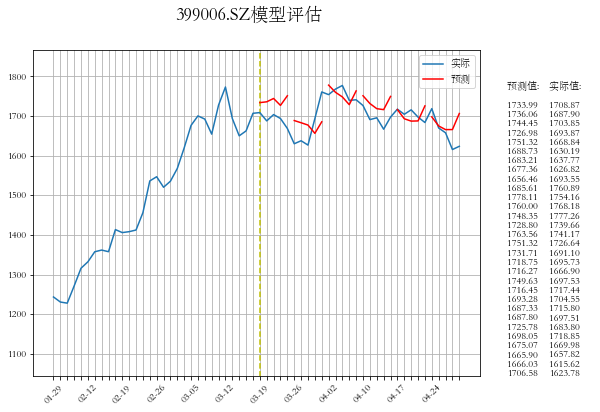

In [52]:
# 本次训练最佳LSTM模型评估(多周期)
from scipy.spatial.distance import pdist
d_list = []

for n in range(len(CODE_LIST)):
    df1 = df_a_list[n].sort_values(by=['trade_date'])[_INPUT_LIST][-(TIMESTEPS+CYCLE*PREDICT_NUM):]
    df2 = df_aa_list[n].sort_values(by=['trade_date'])[CORV_INPUT_LIST][-(TIMESTEPS+CYCLE*PREDICT_NUM):-PREDICT_NUM]
    
    print(df1.tail())
    print(df2.tail())
    scaler,scaler2 = scaler_list2[n]
   
    norm_data = scaler.transform(df1.iloc[:,1:-1])
    norm_data2 = scaler2.transform(df2.iloc[:,:-1])
    
    norm_data = np.concatenate([np.asarray(df1.iloc[:,0:1]), norm_data, np.asarray(df1.iloc[:,-1:])],axis=1)
    norm_data2 = np.concatenate([norm_data2, np.asarray(df2.iloc[:,-1:])],axis=1)
    
    print("norm_data: ",type(norm_data),norm_data.shape)
    print(norm_data[-7:])

    x,y=generate_data(norm_data,1)
    y=np.asarray(df1.iloc[-(CYCLE*PREDICT_NUM):,0:1]).ravel()
    print("y: ",type(y),y.shape)
    print(y)
    x2=generate_data_pred(norm_data2,0)
    print("x shape: ",x.shape, "y shape: ",y.shape,y[-6:])
    print("x2 shape: ",x2.shape)

    y_combo_df = pd.DataFrame()

    s=PREDICT_NUM
    i_list=[i+TIMESTEPS-1 for i,a in enumerate(x) if i % s == 0] #缝5（PREDICT_NUM）的行坐标
    print("i_list: ",len(i_list))
    print(i_list)

    x=np.array([a for i,a in enumerate(x) if i % s == 0], dtype = float)
    x2=np.array([a for i,a in enumerate(x2) if i % s == 0], dtype = float)
    #按缝5（PREDICT_NUM）x进行筛选

    print("x shape: ",x.shape, "y shape: ",y.shape,y[-6:])
    print("x2 shape: ",x2.shape)

    ema_array = norm_data[i_list,0] # 取出CYCLE个T0值
    ema_array = ema_array.repeat(PREDICT_NUM).reshape(CYCLE,PREDICT_NUM) #重复PREDICT_NUM次，形成(CYCLE,PREDICT_NUM)的矩阵
    print("ema_array: ",ema_array.shape)
    print(ema_array)
    ##

    y_,y_pred = model_list2[n].predict([x,x2])
    y_combo = y_*WEIGHT + y_pred*(1-WEIGHT)
    y_combo = (y_combo + 1) * ema_array
    print("y_combo.shape: ",y_combo.shape)

    y_combo = y_combo[np.newaxis,:]
    print(CODE_LIST[n],'y_combo: ',type(y_combo),y_combo.shape)
    print(y_combo)
    print(CODE_LIST[n],'y: ',y)

    y_plot_temp=y
    y_pred_plot_temp=y_combo
    print("y_plot_temp.shape: ",y_plot_temp.shape)
    print("y_pred_plot_temp.shape: ",y_pred_plot_temp.shape)
    
    X=np.vstack([y_plot_temp.ravel(),y_pred_plot_temp.ravel()])
    print('X: ',X)
    
    # d1=pdist(X,'seuclidean')
    d1 = pdist(X, 'cityblock') # 曼哈顿距离
    # print(d1)
    
    print(CODE_LIST[n],'y_plot_temp: ',y_plot_temp)
    print(CODE_LIST[n],'y_pred_plot_temp: ',y_pred_plot_temp)
    print('曼哈顿距离: ',d1)
    
    d_list.append(d1)
    
    y_plot=list(norm_data[:-(CYCLE*PREDICT_NUM),0].ravel()) + list(y_plot_temp.ravel())
    y_pred_plot=list(norm_data[:-(CYCLE*PREDICT_NUM),0].ravel()) + list(y_pred_plot_temp.ravel())
    print(y_plot)
    print(len(y_plot),type(y_plot))
    print(y_pred_plot)
    print(len(y_pred_plot),type(y_plot))

    d__ = np.asarray(df1['trade_date'][-(TIMESTEPS+CYCLE*PREDICT_NUM):].apply(lambda x: datetime.strptime(x, '%Y%m%d').strftime('%m-%d'))).ravel()
    # 将日期格式由'%Y%m%d'转为'%m-%d'
    
    print('d__: ',d__.shape)
    print(d__)
    
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1,1,1)
    
    fig.suptitle(CODE_LIST[n]+'模型评估', fontsize = 18, fontweight='bold')

    xticks = range(0,TIMESTEPS+CYCLE*PREDICT_NUM)
    xticklabels = [d_ if i % PREDICT_NUM ==0 else '' for i,d_ in enumerate(d__)]
    
    print("xticks: ",len(xticks))
    print(xticks)
    print("xticklabels: ",len(xticklabels))
    print(xticklabels)
    
    ax.plot(xticks, y_plot)
    # plt.plot(y_plot,label='实际')
    
    for j in range(CYCLE):
        ax.plot(xticks[TIMESTEPS+j*PREDICT_NUM:TIMESTEPS+(j+1)*PREDICT_NUM], y_pred_plot[TIMESTEPS+j*PREDICT_NUM:TIMESTEPS+(j+1)*PREDICT_NUM], color='r')

    tmp_list = ['{:.2f}'.format(i) for i in list(y_plot_temp.ravel())]
    tmp_pred_list = ['{:.2f}'.format(i) for i in list(y_pred_plot_temp.ravel())]
    
    tmp_array = norm_data[:,0].ravel()
    
    plt.text((TIMESTEPS+CYCLE*PREDICT_NUM) * 1.1,0.85 * tmp_array.min(),'预测值: \r\n\r\n' + '\r\n'.join(tmp_pred_list))
    plt.text((TIMESTEPS+CYCLE*PREDICT_NUM) * 1.2,0.85 * tmp_array.min(),'实际值: \r\n\r\n' + '\r\n'.join(tmp_list))
    
    ax.vlines(TIMESTEPS, 0, tmp_array.max() * 1.05, colors = "y", linestyles = "dashed")    

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=45)

    print("y_plot_temp.max(): ",tmp_array.max())
    #yticks = range(int(0.3 * y_plot_temp.max()) ,int(y_plot_temp.max() * 1.2))
    plt.ylim(int(0.85 * tmp_array.min()) ,int(tmp_array.max() * 1.05))

    plt.legend(['实际','预测'])
    plt.grid(True)
    plt.show()
    
    #del(df_a,df_aa,df1,df2,scaler,scaler2)
    del(df1,df2,scaler,scaler2)

          T0       open       high        low      close          vol  \
4  3201.6137  3203.5588  3210.6508  3156.6070  3201.6137  274872164.0   
3  3123.8261  3190.5851  3193.7494  3123.0258  3123.8261  325879129.0   
2  3086.3989  3108.1635  3129.2134  3085.8049  3086.3989  280873854.0   
1  3062.4985  3090.6331  3107.7605  3050.0261  3062.4985  292114886.0   
0  3078.3389  3052.6223  3088.4074  3052.6223  3078.3389  222302517.0   

        amount   upper_band   lower_band  macd_diff   macd_dea      kdj_k  \
4  278410852.5  3334.796519  3031.994833  53.135045  65.400776  50.970894   
3  309076083.7  3322.584527  3056.276416  42.164174  60.753456  34.151094   
2  274776402.3  3300.131832  3084.793806  30.102613  54.623287  22.869624   
1  289063278.9  3310.047586  3081.311871  18.403037  47.379237  17.058238   
0  225498129.2  3321.412881  3068.763805  10.290604  39.961511  15.485060   

       kdj_d      rsi_6     rsi_14        ar        br trade_date  
4  60.506741  28.020579  47.53

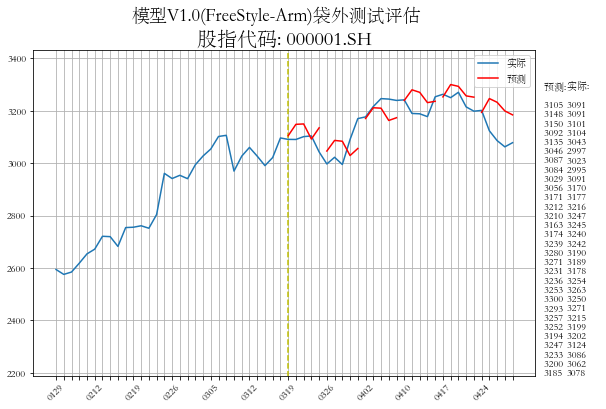

          T0       open       high        low      close          vol  \
4  1718.8461  1690.2788  1721.4213  1676.6381  1718.8461   86336153.0   
3  1669.9777  1709.8287  1723.6622  1669.2360  1669.9777  103488546.0   
2  1657.8243  1664.0430  1682.4578  1653.6913  1657.8243   82295686.0   
1  1615.6164  1658.1915  1661.0592  1611.2157  1615.6164   89788375.0   
0  1623.7819  1612.1090  1634.7120  1608.7209  1623.7819   67089716.0   

        amount   upper_band   lower_band  macd_diff   macd_dea      kdj_k  \
4   99574814.6  1787.170347  1626.684672  18.040363  26.862741  63.391113   
3  112522886.9  1784.032396  1633.611900  13.873512  24.264895  53.876612   
2   96658518.9  1778.565928  1640.988034   9.481280  21.308172  43.077528   
1  104464841.2  1790.577516  1627.909560   2.565012  17.559540  29.961555   
0   75753578.5  1792.169056  1619.673678  -2.231568  13.601319  24.342106   

       kdj_d      rsi_6     rsi_14        ar        br trade_date  
4  53.189137  59.594757  40.97

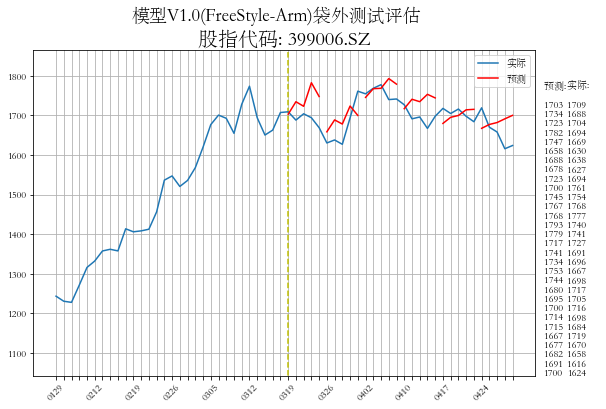

In [53]:
# 原优化LSTM模型评估(多周期)
tuned_d_list = []

for n in range(len(CODE_LIST)):
    df1 = df_a_list[n].sort_values(by=['trade_date'])[_INPUT_LIST][-(TIMESTEPS+CYCLE*PREDICT_NUM):]
    df2 = df_aa_list[n].sort_values(by=['trade_date'])[CORV_INPUT_LIST][-(TIMESTEPS+CYCLE*PREDICT_NUM):-PREDICT_NUM]
    
    print(df1.tail())
    print(df2.tail())
    scaler,scaler2 = scaler_list2[n]
   
    norm_data = scaler.transform(df1.iloc[:,1:-1])
    norm_data2 = scaler2.transform(df2.iloc[:,:-1])
    
    norm_data = np.concatenate([np.asarray(df1.iloc[:,0:1]), norm_data, np.asarray(df1.iloc[:,-1:])],axis=1)
    norm_data2 = np.concatenate([norm_data2, np.asarray(df2.iloc[:,-1:])],axis=1)
    
    print("norm_data: ",type(norm_data),norm_data.shape)
    print(norm_data[-7:])

    x,y=generate_data(norm_data,1)
    y=np.asarray(df1.iloc[-(CYCLE*PREDICT_NUM):,0:1]).ravel()
    print("y: ",type(y),y.shape)
    print(y)
    x2=generate_data_pred(norm_data2,0)
    print("x shape: ",x.shape, "y shape: ",y.shape,y[-6:])
    print("x2 shape: ",x2.shape)

    y_combo_df = pd.DataFrame()

    s=PREDICT_NUM
    i_list=[i+TIMESTEPS-1 for i,a in enumerate(x) if i % s == 0] #缝5（PREDICT_NUM）的行坐标
    print("i_list: ",len(i_list))
    print(i_list)

    x=np.array([a for i,a in enumerate(x) if i % s == 0], dtype = float)
    x2=np.array([a for i,a in enumerate(x2) if i % s == 0], dtype = float)
    #按缝5（PREDICT_NUM）对x进行筛选

    print("x shape: ",x.shape, "y shape: ",y.shape,y[-6:])
    print("x2 shape: ",x2.shape)

    ema_array = norm_data[i_list,0] 
    ema_array = ema_array.repeat(PREDICT_NUM).reshape(CYCLE,PREDICT_NUM) #重复PREDICT_NUM次，形成(CYCLE,PREDICT_NUM)的矩阵
    print("ema_array: ",ema_array.shape)
    print(ema_array)
    ##

    y_,y_pred = tuned_model_list2[n].predict([x,x2])
    y_combo = y_*WEIGHT + y_pred*(1-WEIGHT)
    y_combo = (y_combo + 1) * ema_array
    print("y_combo.shape: ",y_combo.shape)
        
    y_combo = y_combo[np.newaxis,:]
    print(CODE_LIST[n],'y_combo: ',type(y_combo),y_combo.shape)
    print(y_combo)
    print(CODE_LIST[n],'y: ',y)

    y_plot_temp=y
    y_pred_plot_temp=y_combo
    print("y_plot_temp.shape: ",y_plot_temp.shape)
    print("y_pred_plot_temp.shape: ",y_pred_plot_temp.shape)
    
    X=np.vstack([y_plot_temp.ravel(),y_pred_plot_temp.ravel()])
    print('X: ',X)
    
    # d1=pdist(X,'seuclidean')
    d1 = pdist(X, 'cityblock') # 曼哈顿距离
    # print(d1)
    tuned_d_list.append(d1)
    
    print(CODE_LIST[n],'y_plot_temp: ',y_plot_temp)
    print(CODE_LIST[n],'y_pred_plot_temp: ',y_pred_plot_temp)
    print('曼哈顿距离: ',d1)
    
    y_plot=list(norm_data[:-(CYCLE*PREDICT_NUM),0].ravel()) + list(y_plot_temp.ravel())
    y_pred_plot=list(norm_data[:-(CYCLE*PREDICT_NUM),0].ravel()) + list(y_pred_plot_temp.ravel())
    print(y_plot)
    print(len(y_plot),type(y_plot))
    print(y_pred_plot)
    print(len(y_pred_plot),type(y_plot))

    d__ = np.asarray(df1['trade_date'][-(TIMESTEPS+CYCLE*PREDICT_NUM):].apply(lambda x: datetime.strptime(x, '%Y%m%d').strftime('%m%d'))).ravel()
    # 将日期格式由'%Y%m%d'转为'%m-%d'
    
    print('d__: ',d__.shape)
    print(d__)
    
    fig = plt.figure(figsize = (9,6))
    
    #plt.style.use('ggplot')

    ax = fig.add_subplot(1,1,1)
    
    fig.suptitle('模型V1.0(FreeStyle-Arm)袋外测试评估', fontsize = 18, color='k', fontweight='bold')
    
    #ax.set_facecolor('k')
    ax.set_title( '股指代码: ' + CODE_LIST[n] , fontsize = 20, color='k', fontweight='bold')
    xticks = range(0,TIMESTEPS+CYCLE*PREDICT_NUM)
    xticklabels = [d_ if i % PREDICT_NUM ==0 else '' for i,d_ in enumerate(d__)]
    
    print("xticks: ",len(xticks))
    print(xticks)
    print("xticklabels: ",len(xticklabels))
    print(xticklabels)
    
    ax.plot(xticks, y_plot)
    
    for j in range(CYCLE):
        ax.plot(xticks[TIMESTEPS+j*PREDICT_NUM:TIMESTEPS+(j+1)*PREDICT_NUM], y_pred_plot[TIMESTEPS+j*PREDICT_NUM:TIMESTEPS+(j+1)*PREDICT_NUM], color='r')

    tmp_list = ['{:.0f}'.format(i) for i in list(y_plot_temp.ravel())]
    tmp_pred_list = ['{:.0f}'.format(i) for i in list(y_pred_plot_temp.ravel())]
    
    tmp_array = norm_data[:,0].ravel()
    
    plt.text((TIMESTEPS+CYCLE*PREDICT_NUM) * 1.05,0.85 * tmp_array.min(),'预测:\r\n\r\n' + '\r\n'.join(tmp_pred_list))
    plt.text((TIMESTEPS+CYCLE*PREDICT_NUM) * 1.10,0.85 * tmp_array.min(),'实际:\r\n\r\n' + '\r\n'.join(tmp_list))
    
    ax.vlines(TIMESTEPS, 0, tmp_array.max() * 1.05, colors = "y", linestyles = "dashed")    

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=45)

    print("y_plot_temp.max(): ",tmp_array.max())
    #yticks = range(int(0.3 * y_plot_temp.max()) ,int(y_plot_temp.max() * 1.2))
    plt.ylim(int(0.85 * tmp_array.min()) ,int(tmp_array.max() * 1.05))
    
    plt.legend(['实际','预测'])
    plt.grid(True)
    # plt.show()
    
    plt.savefig("pic/" + CODE_LIST[n] + "_test.png")
    plt.show()
    
    #del(df_a,df_aa,df1,df2,scaler,scaler2)
    del(df1,df2,scaler,scaler2)

In [54]:
# 根据比较结果，更新优化LSTM模型
import shutil 

for n in range(len(CODE_LIST)):
    print(d_list[n])
    print(tuned_d_list[n])
    
    if (d_list[n] < tuned_d_list[n]):
        fpath = best_trained_hdf5[n]
        print(fpath)

        path_file = tuned_model_hdf5[n]
        print(path_file)
        
        os.remove(path_file) #删除文件
        #shutil.copy(fpath,path_)
        path_file = fpath.replace("train","tune")
        print(path_file)
        model_list2[n].save(path_file, overwrite=True, include_optimizer=True)
    else:
        # 新模型不如原优化模型稳定，使用原模型预测
        print("using the tuned model for: " + str(n))
        model_list2[n] = tuned_model_list2[n]

[ 1683.05592879]
[ 1740.89099131]
model/train/lstm-0-04-0.016657.hdf5
model/tune\lstm-0-05-0.016377.hdf5
model/tune/lstm-0-04-0.016657.hdf5
[ 1040.02106016]
[ 1144.66036171]
model/train/lstm-1-05-0.025260.hdf5
model/tune\lstm-1-04-0.025096.hdf5
model/tune/lstm-1-05-0.025260.hdf5


In [55]:
import urllib.request as request
import matplotlib.dates as mdates

'''
@query a single date: string '20170401';
@api return day_type: 0 workday 1 weekend 2 holiday -1 err
@function return day_type: 1 workday 0 weekend&holiday
'''
d = timedelta(days=1)

In [56]:
# 判断日期假日类型
def get_day_type(query_date):
    url = 'http://tool.bitefu.net/jiari/?d=' + query_date
    resp = request.urlopen(url)
    content = resp.read()
    if content:
        try:
            day_type = int(content)
        except ValueError:
            return -1
        else:
            return day_type
    else:
        return -1

In [57]:
# 判断是否交易日
def is_tradeday(query_date):
    weekday = datetime.strptime(query_date, '%Y%m%d').isoweekday()
    if weekday <= 5 and get_day_type(query_date) == 0:
        return 1
    else:
        return 0

<class 'list'> [datetime.date(2019, 3, 19), datetime.date(2019, 3, 20), datetime.date(2019, 3, 21), datetime.date(2019, 3, 22), datetime.date(2019, 3, 25), datetime.date(2019, 3, 26), datetime.date(2019, 3, 27), datetime.date(2019, 3, 28), datetime.date(2019, 3, 29), datetime.date(2019, 4, 1), datetime.date(2019, 4, 2), datetime.date(2019, 4, 3), datetime.date(2019, 4, 4), datetime.date(2019, 4, 8), datetime.date(2019, 4, 9), datetime.date(2019, 4, 10), datetime.date(2019, 4, 11), datetime.date(2019, 4, 12), datetime.date(2019, 4, 15), datetime.date(2019, 4, 16), datetime.date(2019, 4, 17), datetime.date(2019, 4, 18), datetime.date(2019, 4, 19), datetime.date(2019, 4, 22), datetime.date(2019, 4, 23), datetime.date(2019, 4, 24), datetime.date(2019, 4, 25), datetime.date(2019, 4, 26), datetime.date(2019, 4, 29), datetime.date(2019, 4, 30), datetime.date(2019, 5, 6), datetime.date(2019, 5, 7), datetime.date(2019, 5, 8), datetime.date(2019, 5, 9), datetime.date(2019, 5, 10)]
          T0  

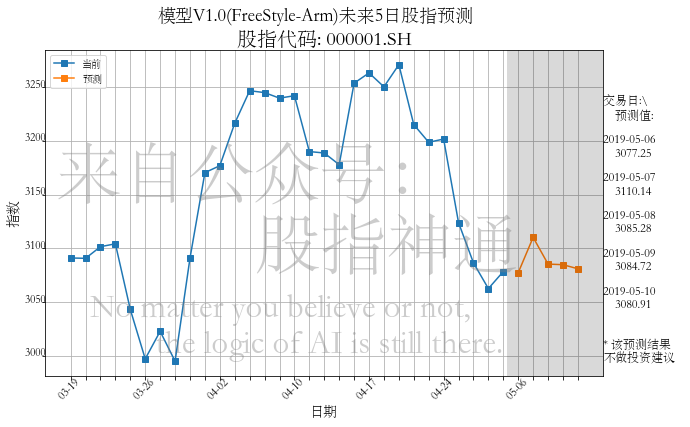

<class 'list'> [datetime.date(2019, 3, 19), datetime.date(2019, 3, 20), datetime.date(2019, 3, 21), datetime.date(2019, 3, 22), datetime.date(2019, 3, 25), datetime.date(2019, 3, 26), datetime.date(2019, 3, 27), datetime.date(2019, 3, 28), datetime.date(2019, 3, 29), datetime.date(2019, 4, 1), datetime.date(2019, 4, 2), datetime.date(2019, 4, 3), datetime.date(2019, 4, 4), datetime.date(2019, 4, 8), datetime.date(2019, 4, 9), datetime.date(2019, 4, 10), datetime.date(2019, 4, 11), datetime.date(2019, 4, 12), datetime.date(2019, 4, 15), datetime.date(2019, 4, 16), datetime.date(2019, 4, 17), datetime.date(2019, 4, 18), datetime.date(2019, 4, 19), datetime.date(2019, 4, 22), datetime.date(2019, 4, 23), datetime.date(2019, 4, 24), datetime.date(2019, 4, 25), datetime.date(2019, 4, 26), datetime.date(2019, 4, 29), datetime.date(2019, 4, 30), datetime.date(2019, 5, 6), datetime.date(2019, 5, 7), datetime.date(2019, 5, 8), datetime.date(2019, 5, 9), datetime.date(2019, 5, 10)]
          T0  

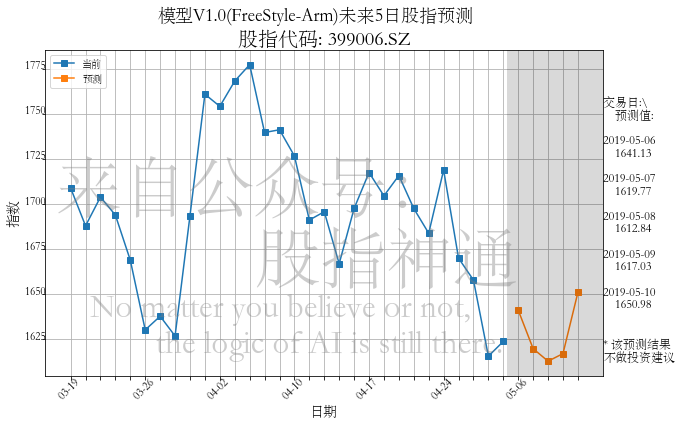

In [58]:
# LSTM2模型预测
font_ax = { \
           'fontsize':11, \
           'fontweight': 'bold', \
           'verticalalignment': 'baseline', \
           'horizontalalignment': 'center'}

for n in range(len(CODE_LIST)):
    df1 = df_a_list[n].sort_values(by=['trade_date'])[_INPUT_LIST][-(TIMESTEPS):]
    df2 = df_aa_list[n].sort_values(by=['trade_date'])[CORV_INPUT_LIST][-(TIMESTEPS):]
    
    df_date = df_a_list[n].sort_values(by=['trade_date'])[["trade_date"]][-(TIMESTEPS):]
    l_date = df_date['trade_date'].tolist()
    xs = [datetime.strptime(d_, '%Y%m%d').date() for d_ in l_date]
    
    #补全一个预测周期的日期（datatime型）
    for i in range(PREDICT_NUM):
        xs_tail = xs[-1] + d
        while is_tradeday(xs_tail.strftime('%Y%m%d')) == 0:
            xs_tail = xs_tail + d
        xs.append(xs_tail)

    print(type(xs),xs)

    print(df1.tail())
    print(df2.tail())
    scaler,scaler2 = scaler_list2[n]
    
    norm_data = scaler.transform(df1.iloc[:,1:-1])
    norm_data2 = scaler2.transform(df2.iloc[:,:-1])
    
    norm_data = np.concatenate([np.asarray(df1.iloc[:,0:1]), norm_data, np.asarray(df1.iloc[:,-1:])],axis=1)
    norm_data2 = np.concatenate([norm_data2, np.asarray(df2.iloc[:,-1:])],axis=1)
    
    print("norm_data: ",type(norm_data),norm_data.shape)
    print(norm_data[-7:])
    
    x=generate_data_pred(norm_data,1)
    x2=generate_data_pred(norm_data2,0)
    print("x shape: ",x.shape)
    print("x2 shape: ",x2.shape)

    y_combo_df = pd.DataFrame()
    y_,y_pred = model_list2[n].predict([x,x2])
    y_combo = y_*WEIGHT + y_pred*(1-WEIGHT)
    y_combo = (y_combo + 1) * norm_data[TIMESTEPS-1,0]
    # print("y_combo.shape: ",y_combo.shape)

    y_combo = y_combo[np.newaxis,:]

    print(CODE_LIST[n],'y_pred: ',y_pred)
    print(CODE_LIST[n],'y_: ',y_)
    print(CODE_LIST[n],'y_combo: ',y_combo)

    y_pred_plot_temp=y_combo
    
    print(CODE_LIST[n],'y_pred_plot_temp: ',y_pred_plot_temp)

    y_pred_plot=list(norm_data[:,0].ravel()) + list(y_pred_plot_temp.ravel()) # 跟评估不一样

    print("y_pred_plot: ",len(y_pred_plot),type(y_pred_plot))
    print(y_pred_plot)

    fig = plt.figure(figsize = (10,6))
    
    # plt.style.use('ggplot')

    ax = fig.add_subplot(1,1,1)
    # fig.subplots_adjust(wspace=0.5,hspace=0.5)

    fig.suptitle('模型V1.0(FreeStyle-Arm)未来5日股指预测', fontsize = 18, color='k', fontweight='bold')
    
    #ax.set_facecolor('k')
    ax.set_title( '股指代码: ' + CODE_LIST[n] , fontsize = 20, color='k', fontweight='bold')
    ax.set_xlabel("日期",fontsize=14, fontweight='bold')
    ax.set_ylabel("指数",fontsize=14, fontweight='bold')
    
    xticks = range(len(xs))
    # xticklabels = [d_.strftime('%Y-%m-%d') for d_ in xs]
    xticklabels = [((d_.strftime('%m-%d') + ' ') if i % PREDICT_NUM ==0 else ' ')for i,d_ in enumerate(xs)]

    ax.plot(xticks[:TIMESTEPS],y_pred_plot[:-PREDICT_NUM],marker='s')
    ax.plot(xticks[TIMESTEPS:],y_pred_plot[-PREDICT_NUM:],marker='s')
    
    tmp_date_list = [d_.strftime('%Y-%m-%d') for i,d_ in enumerate(xs)]
    tmp_pred_list = ['{:.2f}'.format(i) for i in y_pred_plot]
    tmp_array = np.array(y_pred_plot)

    print(tmp_date_list)
    plt.text((TIMESTEPS+PREDICT_NUM) * 1.02,1.005 * tmp_array.min(), \
             '交易日:\\\r\n\r\n\r\n' + '\r\n\r\n\r\n'.join(tmp_date_list[-PREDICT_NUM:]) + '\r\n\r\n\r\n\r\n', fontsize=12)
    plt.text((TIMESTEPS+PREDICT_NUM) * 1.02,1.000 * tmp_array.min(), \
             '    预测值:\r\n\r\n\r\n    ' + '\r\n\r\n\r\n    '.join(tmp_pred_list[-PREDICT_NUM:]) + '\r\n\r\n\r\n* 该预测结果\r\n不做投资建议', fontsize=12)
    
    # position bottom right
    plt.text(TIMESTEPS-1, tmp_array.min(), 'No matter you believe or not,\r\n the logic of AI is still there.',fontsize=33, color='gray',ha='right', va='bottom', alpha=0.4)
    plt.text(TIMESTEPS, (tmp_array.mean() + tmp_array.min()) / 2, '来自公众号：\r\n股指神通',fontsize=66, color='gray',ha='right', va='bottom', alpha=0.4)
    
    ax.axvline(xticks[TIMESTEPS] + 2.5, color="k", linewidth=plt.rcParams['lines.linewidth'] * 66, linestyle = '-', alpha=0.15)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontdict=font_ax, rotation=45)
    
    print("ax.get_yticks(): ",ax.get_yticks())
    ysticks = ax.get_yticks()
    yticklabels = [(str(int(i)) + '  ') for i in ysticks]
    ax.set_yticklabels(yticklabels,fontdict=font_ax)

    plt.legend(('当前', '预测'))
    plt.grid(True)

    plt.savefig("pic/" + CODE_LIST[n] + "_prod.png")
    plt.show()
    
    del(df1,df2,scaler)